In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from matplotlib.pylab import rcParams
from sklearn.preprocessing import StandardScaler
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import cohen_kappa_score
from itertools import combinations
from sklearn.metrics import roc_auc_score
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import f1_score

import kdn
import pruning
import diversity

/home/CIN/jvcm/mcsenv/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Pre processing

In [2]:
data = pd.read_csv('../kc1.csv')

In [3]:
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
len(X)

2109

In [4]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

### Analysis

In [5]:
skf = StratifiedKFold(n_splits=10, shuffle=True)

metrics_bag = np.zeros(4)
metrics_best = np.zeros((3, 4))
metrics_red = np.zeros((3, 4))

divers_best = np.zeros((3,2))
divers_red = np.zeros((3,2))

for train_index, test_index in skf.split(X, y):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
            
    sm = SMOTE()
    X_train, y_train = sm.fit_sample(X_train, y_train)

    #---------------------------------------BAGGING ORIGINAL---------------------------------------#
    bg = BaggingClassifier(Perceptron(max_iter = 150, tol = 0.001),
                         n_estimators = 100)
    bg.fit(X_train, y_train)
    AUX = bg.estimators_[:]
    metrics_bag += np.array([bg.score(X_test, y_test),
                            roc_auc_score(y_test, bg.predict_proba(X_test)[:,1]),
                            geometric_mean_score(y_test, bg.predict(X_test)),
                            f1_score(y_test, bg.predict(X_test))])
    #---------------------------------------------------------------------------------------------#
    
    easy = []
    hard = []
    vis = kdn.kDN(X_train, y_train)
    for i, k in enumerate(vis):
        if k < 0.4:
            easy.append(i)
        else: 
            hard.append(i)
            
    #--------------------------------------BAGGING PODADO-----------------------------------------#
    all_ = list(range(len(y_train)))
    valid = [all_, hard, easy]
    for i, val in enumerate(valid):
        print(i)
        bg.estimators_ = AUX[:]
        
        prune1 = pruning.best_first(bg, X_train[val], y_train[val])
        prune2 = pruning.reduce_error(bg, X_train[val], y_train[val])
        
        #--------------------------------------BEST FIRST-----------------------------------------#
        divers_best[i, :] += np.array([diversity.disagreement(prune1, X_train, y_train),
                                      diversity.kappa(prune1, X_train, y_train)])
        bg.estimators_ = prune1       
        metrics_best[i, :] += np.array([bg.score(X_test, y_test),
                            roc_auc_score(y_test, bg.predict_proba(X_test)[:,1]),
                            geometric_mean_score(y_test, bg.predict(X_test)),
                            f1_score(y_test, bg.predict(X_test))])       
                
        #-------------------------------------REDUCE ERROR----------------------------------------#
        divers_red[i, :] += np.array([diversity.disagreement(prune2, X_train, y_train),
                                      diversity.kappa(prune2, X_train, y_train)])
        bg.estimators_ = prune2
        metrics_red[i,:] += np.array([bg.score(X_test, y_test),
                            roc_auc_score(y_test, bg.predict_proba(X_test)[:,1]),
                            geometric_mean_score(y_test, bg.predict(X_test)),
                            f1_score(y_test, bg.predict(X_test))])
    
    #---------------------------------------------------------------------------------------------#
    
metrics_bag = metrics_bag / skf.n_splits

metrics_best = metrics_best / skf.n_splits
metrics_red = metrics_red / skf.n_splits

divers_best = divers_best / skf.n_splits
divers_red = divers_red / skf.n_splits

print('Bagging:')
print('Metricas:', metrics_bag, '\n \n \n')
print('Best first:')
print('Metricas:', metrics_best)
print('Diversidade:', divers_best, '\n \n \n')
print('Reduce Error:')
print('Metricas:', metrics_red)
print('Diversidade:', divers_red, '\n \n \n')

0
*best 4
*red 9
1
*best 2
*red 2
2
*best 5
*red 3
0
*best 5
*red 10
1
*best 6
*red 2
2
*best 9
*red 5
0
*best 20
*red 5
1
*best 4
*red 2
2
*best 3
*red 3
0
*best 3
*red 5
1
*best 3
*red 2


/home/CIN/jvcm/mcsenv/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/CIN/jvcm/mcsenv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2
*best 5
*red 3
0
*best 4
*red 6
1
*best 2
*red 2
2
*best 3
*red 3
0
*best 9
*red 7
1
*best 2
*red 2
2
*best 3
*red 5
0
*best 10
*red 8
1
*best 4
*red 2
2
*best 3
*red 3
0
*best 8
*red 5
1
*best 2
*red 2
2


/home/CIN/jvcm/mcsenv/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


*best 7
*red 3
0
*best 6
*red 9
1
*best 6
*red 2
2
*best 3
*red 5
0
*best 3
*red 3
1
*best 2
*red 2
2
*best 3
*red 7
Bagging:
Metricas: [0.73157192 0.77755998 0.71835541 0.44847518] 
 
 

Best first:
Metricas: [[0.70643281 0.76758413 0.71358642 0.4351052 ]
 [0.47129491 0.33111089 0.31392    0.12710751]
 [0.66897793 0.75119843 0.71328686 0.42598173]]
Diversidade: [[0.10869704 0.78156003]
 [0.3293483  0.33500152]
 [0.09687389 0.80148578]] 
 
 

Reduce Error:
Metricas: [[0.71070941 0.74334057 0.69827911 0.42241896]
 [0.62173865 0.42215681 0.23211884 0.08559977]
 [0.66093673 0.75891215 0.70974589 0.42098331]]
Diversidade: [[0.29151871 0.4198845 ]
 [0.42444857 0.11108302]
 [0.22259204 0.54883466]] 
 
 



### Bagging Original

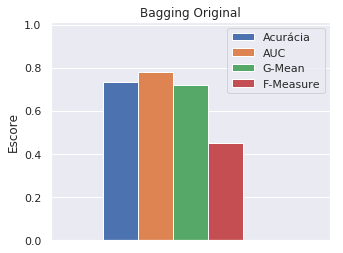

   Acurácia      AUC    G-Mean  F-Measure
0  0.731572  0.77756  0.718355   0.448475


In [6]:
rcParams['figure.figsize'] = 5, 4
barWidth = 0.1
# Set position of bar on X axis
x = [0,barWidth,2*barWidth,3*barWidth]

# Make the plot
plt.bar(x[0], metrics_bag[0], width=barWidth, edgecolor='white', label='Acurácia')
plt.bar(x[1], metrics_bag[1], width=barWidth, edgecolor='white', label='AUC')
plt.bar(x[2], metrics_bag[2], width=barWidth, edgecolor='white', label='G-Mean')
plt.bar(x[3], metrics_bag[3], width=barWidth, edgecolor='white', label='F-Measure')

# Add xticks on the middle of the group bars
plt.ylim([0., 1.01])
plt.xlim([-0.2,0.6])
plt.xticks([])
plt.ylabel('Escore')

# Create legend & Show graphic
plt.legend(loc = 'upper right')
plt.title('Bagging Original')
plt.show()

df = pd.DataFrame(data = np.reshape(metrics_bag, (1,4)), columns = ['Acurácia', 'AUC', 'G-Mean', 'F-Measure'])
print(df)

### Best First

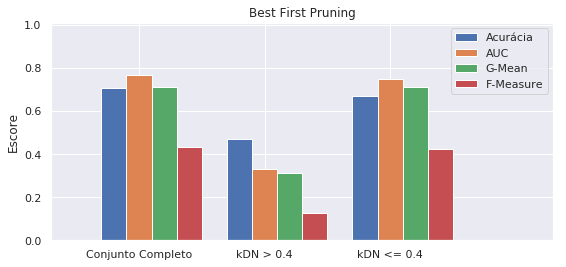

            Acurácia       AUC    G-Mean  F-Measure
Completo    0.706433  0.767584  0.713586   0.435105
kDN > 0.4   0.471295  0.331111  0.313920   0.127108
kDN <= 0.4  0.668978  0.751198  0.713287   0.425982


In [7]:
rcParams['figure.figsize'] = 9, 4
barWidth = 0.2
# Set position of bar on X axis
r1 = np.arange(metrics_best.shape[0])
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

# Make the plot
plt.bar(r1, metrics_best[:, 0], width=barWidth, edgecolor='white', label='Acurácia')
plt.bar(r2, metrics_best[:, 1], width=barWidth, edgecolor='white', label='AUC')
plt.bar(r3, metrics_best[:, 2], width=barWidth, edgecolor='white', label='G-Mean')
plt.bar(r4, metrics_best[:, 3], width=barWidth, edgecolor='white', label='F-Measure')

# Add xticks on the middle of the group bars
plt.ylim([0., 1.01])
plt.xlim([-0.5, 3.5])
plt.ylabel('Escore')
plt.xticks([r + barWidth for r in range(metrics_best.shape[0])], ['Conjunto Completo', 'kDN > 0.4', 'kDN <= 0.4'])

# Create legend & Show graphic
plt.legend(loc = 'upper right')
plt.title('Best First Pruning')
plt.show()

df = pd.DataFrame(data = metrics_best, columns = ['Acurácia', 'AUC', 'G-Mean', 'F-Measure'], index = ['Completo', "kDN > 0.4", "kDN <= 0.4"])
print(df)

### Reduce Error

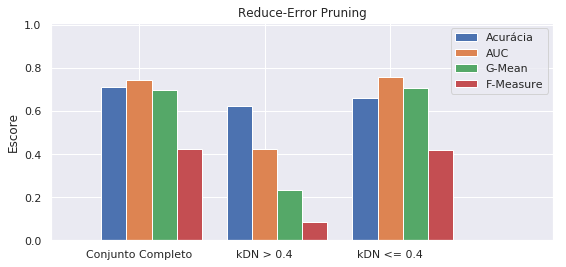

            Acurácia       AUC    G-Mean  F-Measure
Completo    0.710709  0.743341  0.698279   0.422419
kDN > 0.4   0.621739  0.422157  0.232119   0.085600
kDN <= 0.4  0.660937  0.758912  0.709746   0.420983


In [8]:
cenario = ['Conjunto Original', 'Instâncias Difíceis (kDN > 0.4)', 'Instâncias Fáceis (kDN <= 0.4)']
rcParams['figure.figsize'] = 9, 4
barWidth = 0.2
# Set position of bar on X axis
r1 = np.arange(metrics_red.shape[0])
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

# Make the plot
plt.bar(r1, metrics_red[:, 0], width=barWidth, edgecolor='white', label='Acurácia')
plt.bar(r2, metrics_red[:, 1], width=barWidth, edgecolor='white', label='AUC')
plt.bar(r3, metrics_red[:, 2], width=barWidth, edgecolor='white', label='G-Mean')
plt.bar(r4, metrics_red[:, 3], width=barWidth, edgecolor='white', label='F-Measure')

# Add xticks on the middle of the group bars
plt.ylim([0., 1.01])
plt.xlim([-0.5, 3.5])
plt.ylabel('Escore')
plt.xticks([r + barWidth for r in range(metrics_red.shape[0])], ['Conjunto Completo', 'kDN > 0.4', 'kDN <= 0.4'])

# Create legend & Show graphic
plt.legend(loc = 'upper right')
plt.title('Reduce-Error Pruning')
plt.show()

df = pd.DataFrame(data = metrics_red, columns = ['Acurácia', 'AUC', 'G-Mean', 'F-Measure'], index = ['Completo', "kDN > 0.4", "kDN <= 0.4"])
print(df)